# Load data and assessments - Sofia on QC

In [1]:
import pandas as pd
import numpy as np
assFile = "../Data/depression2016/depression2016/CS120Data/CS120Clinical/CS120Final_Screener.xlsx"
xls = pd.ExcelFile(assFile)
df = xls.parse('Sheet1', skiprows=range(1,83),converters={'ID':str})

# read data
import pickle
with open('data.dat','rb') as f:
    data, subjects = pickle.load(f)
f.close()

# defining groups based on screening data (week 0)
groups = ['Depressed & Anxious','Anxious only','Depressed only','Control']
indg = [np.array([],dtype=int) for i in range(4)]
for i in range(len(data)):
    ind, = np.where(subjects[i]==df.ID)
    #print(df.DEPRESSED_ANXIOUS[ind], np.isnan(df.DEPRESSED_ANXIOUS[ind]))
    if ind:
        if ~np.isnan(df.DEPRESSED_ANXIOUS[ind[0]]):
            indg[0] = np.append(indg[0], i)
        elif ~np.isnan(df.ANXIOUS[ind[0]]):
            indg[1] = np.append(indg[1], i)
        elif ~np.isnan(df.DEPRESSED[ind[0]]):
            indg[2] = np.append(indg[2], i)
        elif ~np.isnan(df.CONTROL[ind[0]]):
            indg[3] = np.append(indg[3], i)
        else:
            print('ERROR')



# Load data and assessments - Sohrob

In [ ]:
import pickle
import pandas as pd
import numpy as np


# read data
with open('data.dat','rb') as f:
    data, subjects = pickle.load(f)
f.close()

# read assessments
with open('assessment.dat', 'rb') as f:
    ass = pickle.load(f)
f.close()

# defining groups based on screening data (week 0)
groups = ['Depressed & Anxious','Anxious only','Depressed only','Control']
indg = [np.array([],dtype=int) for i in range(4)]
for i in range(len(data)):
    ind = np.where(subjects[i]==ass['ID'])[0][0]
    if ind:
        if ass.loc[ind,'PHQ9 W0']>=10 and ass.loc[ind,'GAD7 W0']>=10:
            indg[0] = np.append(indg[0], i)
        elif ass.loc[ind,'PHQ9 W0']<10 and ass.loc[ind, 'GAD7 W0']>=10:
            indg[1] = np.append(indg[1], i)
        elif ass.loc[ind, 'PHQ9 W0']>=10 and ass.loc[ind,'GAD7 W0']<10:
            indg[2] = np.append(indg[2], i)
        elif ass.loc[ind, 'PHQ9 W0']<10 and ass.loc[ind,'GAD7 W0']<10:
            indg[3] = np.append(indg[3], i)
        else:
            print('ERROR')

# Run bootstrapping in groups

In [3]:
from psm_causal_effects import psm_causal_effects
from extract_remove_nans import extract_remove_nans
n_boot = 100
scorefunction = 'replacement'
output = 'difference'
var_threshold = 0.5

es_m2s_mean = np.zeros([n_boot,4])
es_s2m_mean = np.zeros([n_boot,4])
es_s2m_um_mean = np.zeros([n_boot,4])
es_m2s_um_mean = np.zeros([n_boot,4])
    
for g in range(len(groups)):
    
    print(groups[g]+':')

    for k in range(n_boot):

        print (k),

        inds = np.random.choice(indg[g], size=indg[g].size, replace=True)

        es_s2m = np.zeros([indg[g].size,1])
        es_m2s = np.zeros([indg[g].size,1])
        es_s2m_um = np.zeros([indg[g].size,1])
        es_m2s_um = np.zeros([indg[g].size,1])

        for (c,i) in enumerate(inds):

            if np.nanstd(data[i]['mood'])<var_threshold or np.nanstd(data[i]['quality'])<var_threshold:
                print('skipping subject '+str(i)+' due to low variance in mood or sleep quality.')
                es_m2s_um[c] = np.nan
                es_m2s[c] = np.nan
                es_s2m_um[c] = np.nan
                es_s2m[c] = np.nan
                continue

            # mood on sleep - lag 0 - unmatched
            treatment = 'mood_prev'
            outcome = 'quality'
            data_s = extract_remove_nans(data[i], [treatment]+[outcome])
            es_m2s_um[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=[], scorefun='unmatched', output=output)

            # mood on sleep - lag 1
            confound = ['dow', 'mean_temp_prev2', 'clear_prev2', 'act_prev2','daytype','stress_prev2','energy_prev2','focus_prev2','mood_prev2','quality_prev']
            data_s = extract_remove_nans(data[i], [treatment]+[outcome]+confound)
            es_m2s[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=data_s[confound], scorefun=scorefunction, output=output)

            ################ sleep on mood

            # sleep on mood - lag 0 - unmatched
            treatment = 'quality'
            outcome = 'mood'
            data_s = extract_remove_nans(data[i], [treatment]+[outcome])
            es_s2m_um[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=[], scorefun='unmatched', output=output)

            # sleep on mood - lag 1
            confound = ['dow', 'mean_temp_prev', 'clear_prev','act_prev','daytype','stress_prev','energy_prev','focus_prev','mood_prev','quality_prev']
            data_s = extract_remove_nans(data[i], [treatment]+[outcome]+confound)
            es_s2m[c] = psm_causal_effects(treatment=data_s[treatment], outcome=data_s[outcome], confound=data_s[confound], scorefun=scorefunction, output=output)

        es_m2s_mean[k,g] = np.nanmean(es_m2s, axis=0)
        es_s2m_mean[k,g] = np.nanmean(es_s2m, axis=0)
        es_m2s_um_mean[k,g] = np.nanmean(es_m2s_um, axis=0)
        es_s2m_um_mean[k,g] = np.nanmean(es_s2m_um, axis=0)

 Depressed & Anxious:
0 skipping subject 42 due to low variance in mood or sleep quality.
1 skipping subject 42 due to low variance in mood or sleep quality.
skipping subject 148 due to low variance in mood or sleep quality.
skipping subject 148 due to low variance in mood or sleep quality.
skipping subject 148 due to low variance in mood or sleep quality.
skipping subject 148 due to low variance in mood or sleep quality.
2 skipping subject 42 due to low variance in mood or sleep quality.
skipping subject 42 due to low variance in mood or sleep quality.
skipping subject 42 due to low variance in mood or sleep quality.
3 skipping subject 148 due to low variance in mood or sleep quality.
4 skipping subject 148 due to low variance in mood or sleep quality.
skipping subject 148 due to low variance in mood or sleep quality.
skipping subject 42 due to low variance in mood or sleep quality.
skipping subject 148 due to low variance in mood or sleep quality.
skipping subject 42 due to low varia

In [42]:
# compute standard errors
es_m2s_um_sterr = np.divide(np.std(es_m2s_um_mean, axis=0), np.sqrt(len(subjects)))
print(es_m2s_um_sterr)
es_s2m_um_sterr = np.divide(np.std(es_s2m_um_mean, axis=0), np.sqrt(len(subjects)))
print(es_s2m_um_sterr)

es_m2s_sterr = np.divide(np.std(es_m2s_mean, axis=0), np.sqrt(len(subjects)))
print(es_m2s_sterr)
es_s2m_sterr = np.divide(np.std(es_s2m_mean, axis=0), np.sqrt(len(subjects)))
print(es_s2m_sterr)


es_m2s_um_std = np.std(es_m2s_um_mean, axis=0)
print(es_m2s_um_std)
es_s2m_um_std = np.std(es_s2m_um_mean, axis=0)
print(es_s2m_um_std)

es_m2s_std =np.std(es_m2s_mean, axis=0)
print(es_m2s_std)
es_s2m_std = np.std(es_s2m_mean, axis=0)
print(es_s2m_std)


[ 0.00452474  0.00495344  0.00517135  0.0040051 ]
[ 0.00427647  0.00536677  0.00424077  0.00582276]
[ 0.00748714  0.01135122  0.00964098  0.00712377]
[ 0.0061169   0.00857921  0.00865821  0.01430189]
[ 0.06494221  0.07109523  0.0742228   0.05748401]
[ 0.06137885  0.07702761  0.06086653  0.08357237]
[ 0.10746071  0.16292066  0.13837414  0.10224535]
[ 0.0877941   0.12313484  0.12426876  0.20527068]


## Save Results

In [5]:
df = pd.DataFrame(es_s2m_um_mean)
df.to_csv('results.csv')

## Group Difference

('P = ', 1.8930410687229611e-19)
('P = ', 1.7439002871997964e-40)
('P = ', 1.2653669776629401e-07)
('P = ', 2.1446547533874242e-10)
('P = ', 1.0003156888532073e-13)
('P = ', 0.028814840292765008)
('P = ', 0.86090631498259096)
('P = ', 1.4554665018158797e-15)
('P = ', 0.20279797121687629)
('P = ', 9.431286012004095e-40)
('P = ', 5.595510722296197e-07)
('P = ', 1.6781748265501231e-24)


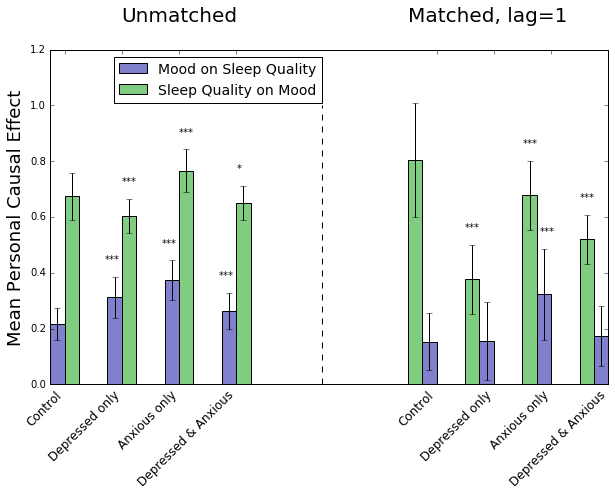

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

groups = ['Depressed & Anxious','Anxious only','Depressed only','Control']

plt.figure(figsize=(10,6))
order= [3, 2, 1, 0]
for i in range(4):
    plt.bar(-4.75+i, np.mean(es_m2s_um_mean[:, order[i]]), yerr =es_m2s_um_std[order[i]],ecolor=(0,0,0),width=.25,color=(.5,.5,.8))
    
    plt.bar(-4.5+i, np.mean(es_s2m_um_mean[:, order[i]]), yerr =es_s2m_um_std[order[i]],ecolor=(0,0,0),width=.25,color=(.5,.8,.5))

    
for i in range(4):
    plt.bar(1.75+i, np.mean(es_m2s_mean[:, order[i]]), yerr =es_m2s_std[order[i]],ecolor=(0,0,0),width=.25,color=(.5,.5,.8))
    
    plt.bar(1.5+i, np.mean(es_s2m_mean[:, order[i]]), yerr =es_s2m_std[order[i]],ecolor=(0,0,0),width=.25,color=(.5,.8,.5))

# unmatched mood on sleep pvals
for i in range(4):
    if order[i] == 3:
        continue
    t,p = ttest_ind(es_m2s_um_mean[:,order[i]], es_m2s_um_mean[:,3], equal_var=False, axis=0)
    print('P = ',p)
    if p<0.001:
        plt.text(-4.8+i, np.mean(es_m2s_um_mean[:,order[i]])+es_m2s_um_std[order[i]]+0.05, '***', fontsize=10)
    elif p<0.01:
        plt.text(-4.8+i, np.mean(es_m2s_um_mean[:,order[i]])+es_m2s_um_std[order[i]]+0.05, '**', fontsize=10)
    elif p<0.05:
        plt.text(-4.8+i, np.mean(es_m2s_um_mean[:,order[i]])+es_m2s_um_std[order[i]]+0.05, '*', fontsize=10)

# unmatched sleep on mood pvals      
for i in range(4):
    if order[i] == 3:
        continue
    t,p = ttest_ind(es_s2m_um_mean[:,order[i]], es_s2m_um_mean[:,3], equal_var=False, axis=0)
    print('P = ',p)
    if p<0.001:
        plt.text(-4.5+i, np.mean(es_s2m_um_mean[:,order[i]])+es_s2m_um_std[order[i]]+0.05, '***', fontsize=10)
    elif p<0.01:
        plt.text(-4.5+i, np.mean(es_s2m_um_mean[:,order[i]])+es_s2m_um_std[order[i]]+0.05, '**', fontsize=10)
    elif p<0.05:
        plt.text(-4.5+i, np.mean(es_s2m_um_mean[:,order[i]])+es_s2m_um_std[order[i]]+0.05, '*', fontsize=10)
        
        
# unmatched mood on sleep pvals
for i in range(4):
    if order[i] == 3:
        continue
    t,p = ttest_ind(es_m2s_mean[:,order[i]], es_m2s_mean[:,3], equal_var=False, axis=0)
    print('P = ',p)
    if p<0.001:
        plt.text(1.8+i, np.mean(es_m2s_mean[:,order[i]])+es_m2s_std[order[i]]+0.05, '***', fontsize=10)
    elif p<0.01:
        plt.text(1.8+i, np.mean(es_m2s_mean[:,order[i]])+es_m2s_std[order[i]]+0.05, '**', fontsize=10)
    elif p<0.05:
        plt.text(1.8+i, np.mean(es_m2s_mean[:,order[i]])+es_m2s_std[order[i]]+0.05, '*', fontsize=10)

# unmatched sleep on mood pvals      
for i in range(4):
    if order[i] == 3:
        continue
    t,p = ttest_ind(es_s2m_mean[:,order[i]], es_s2m_mean[:,3], equal_var=False, axis=0)
    print('P = ',p)
    if p<0.001:
        plt.text(1.5+i, np.mean(es_s2m_mean[:,order[i]])+es_s2m_std[order[i]]+0.05, '***', fontsize=10)
    elif p<0.01:
        plt.text(1.5+i, np.mean(es_s2m_mean[:,order[i]])+es_s2m_std[order[i]]+0.05, '**', fontsize=10)
    elif p<0.05:
        plt.text(1.5+i, np.mean(es_s2m_mean[:,order[i]])+es_s2m_std[order[i]]+0.05, '*', fontsize=10)
    
# # plt.text(-.2, .75, '***', fontsize=14)
# # plt.text(1.8, .70, '***', fontsize=14)
# # plt.text(2.8, .72, '***', fontsize=14)
# # plt.text(3.8, .74, '***', fontsize=14)
# # plt.text(4.8, .84, '***', fontsize=14)
#a = plt.ylim([0,1])
# # plt.xlim([-.5,5.5])
g = [groups[i] for i in order]
plt.xticks([-4.5,-3.5,-2.5,-1.5,2,3,4,5],g*2, rotation=45, fontsize=12, ha='right');

plt.ylabel('Mean Personal Causal Effect',fontsize=18)
# plt.xlabel('lags 0 to T',fontsize=18)
plt.legend(['Mood on Sleep Quality','Sleep Quality on Mood'],loc='upper right',bbox_to_anchor=(.5, 1), fontsize=14);
plt.plot([0,0],[a[0],a[1]],'--',color=(0,0,0))

plt.text(-3.5, 1.3, 'Unmatched', fontsize=20)
plt.text(1.5, 1.3, 'Matched, lag=1', fontsize=20)

## Linear Output

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,5))
yerrs = np.array([[np.mean(es_m2s_um_mean)-np.percentile(es_m2s_um_mean,2.5),np.mean(es_m2s_mean[:,0])-np.percentile(es_m2s_mean[:,0],2.5),\
    np.mean(es_m2s_mean[:,1])-np.percentile(es_m2s_mean[:,1],2.5),np.mean(es_m2s_mean[:,2])-np.percentile(es_m2s_mean[:,2],2.5),\
    np.mean(es_m2s_mean[:,3])-np.percentile(es_m2s_mean[:,3],2.5)],\
    [np.percentile(es_m2s_um_mean,97.5)-np.mean(es_m2s_um_mean),np.percentile(es_m2s_mean[:,0],97.5)-np.mean(es_m2s_mean[:,0]),\
    np.percentile(es_m2s_mean[:,1],97.5)-np.mean(es_m2s_mean[:,1]),np.percentile(es_m2s_mean[:,2],97.5)-np.mean(es_m2s_mean[:,2]),\
    np.percentile(es_m2s_mean[:,3],97.5)-np.mean(es_m2s_mean[:,3])]])
plt.bar([-.25,1.75,2.75,3.75,4.75],np.concatenate([np.array([np.mean(es_m2s_um_mean)]),np.mean(es_m2s_mean,axis=0)],axis=0).reshape([5,1]),yerr=yerrs,\
    ecolor=(0,0,0),width=.25,color=(.5,.5,.8))
yerrs = np.array([[np.mean(es_s2m_um_mean)-np.percentile(es_s2m_um_mean,2.5),np.mean(es_s2m_mean[:,0])-np.percentile(es_s2m_mean[:,0],2.5),\
    np.mean(es_s2m_mean[:,1])-np.percentile(es_s2m_mean[:,1],2.5),np.mean(es_s2m_mean[:,2])-np.percentile(es_s2m_mean[:,2],2.5),\
    np.mean(es_s2m_mean[:,3])-np.percentile(es_s2m_mean[:,3],2.5)],\
    [np.percentile(es_s2m_um_mean,97.5)-np.mean(es_s2m_um_mean),np.percentile(es_s2m_mean[:,0],97.5)-np.mean(es_s2m_mean[:,0]),\
    np.percentile(es_s2m_mean[:,1],97.5)-np.mean(es_s2m_mean[:,1]),np.percentile(es_s2m_mean[:,2],97.5)-np.mean(es_s2m_mean[:,2]),\
    np.percentile(es_s2m_mean[:,3],97.5)-np.mean(es_s2m_mean[:,3])]])
plt.bar([0,2,3,4,5],np.concatenate([np.array([np.mean(es_s2m_um_mean)]),np.mean(es_s2m_mean,axis=0)],axis=0).reshape([5,1]),yerr=yerrs,\
    ecolor=(0,0,0),width=.25,color=(.5,.8,.5))
a = plt.ylim([-.1,1])
plt.xlim([-.5,5.5])
plt.xticks([0,2,3,4,5],['unmatched', 'T=0','T=1','T=2','T=3'],rotation=0);
plt.ylabel('Mean Personal Slope',fontsize=14)
plt.xlabel('lags 0 to T',fontsize=14)
plt.legend(['Mood on Sleep Quality','Sleep Quality on Mood'],loc='upper right',bbox_to_anchor=(1, 1), fontsize=10);
plt.plot([1,1],[a[0],a[1]],'--',color=(0,0,0))
plt.plot([-.5,5.5],[0,0],':',color=(0,0,0))

In [ ]:
es_m2s_mean.shape